## Portfolio Optimization

CS524: Introduction to Optimization
> Team: MAHALAKSHMI SUNDARESAN <msundaresan2@wisc.edu> and  MEHMET MUSTAFA MUSABEYLI <musabeyli@wisc.edu>

## Introduction

Optimization’s main goal can be determined as the “best” decision from a set of possible decisions. What’s more applicable than to apply this concept in determining which stocks to invest in? We have identified 10 different companies. Namely these companies are: 

>nordStorm, ctlStock, MylanStock, MacyStock, Kohls, AMD, MKTX, Netflix, Disney, Eros

The data is obtained through https://www.tiingo.com 's free public available APIs.

## What are we doing?

We are trying to optimize which and how many companies we should invest our limited budget of 1000$ to obtain our targets, namely 100 dollars and 50 dollars.


# This model answers the following questions:
    1. Is it better to invest in 3 or 4 stocks?
    2. Is setting a higher target of 100 dollars advisable/realizable?
    3. Will diversification of the portfolio yield a better gain?

## Description

This model, first gets the data, 2016-10-10 to 2018-10-10 end of day stock listing prices, from Tiingo's publicly avaialable Stock Price APIs. Then, through calculating covariance and mean, our GAMS model which is based on Markowitz model, is going to optimize which stocks should we choose by minimizing the risk(variance) as stated in the Markowitz model. 

Then, we will do a prediction over the period of 30 days to get the end of day stock prices of November 9th 2018 using two methods: moving average and linear regression.

We will assume that the investor will buy on 10th October 2018 and sell it on 9th of November 2018. So the profit or loss will be calculated through deducting the price of stock on 9th of November from 10th of October multiplied by number of shares bought based upon our GAMS model.

In [1]:
#Required for projections
import quandl
import numpy as np 

In [2]:
%%bash
pip install scikit-learn --user

In [3]:
#Required for projections
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

In [4]:
%load_ext gams_magic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
%%gams
set i "companies"/nordStorm,ctlStock,MylanStock,MacyStock,Kohls,AMD,MKTX,Netflix,Disney,Eros /;
parameter mean(i) "mean of each company's stock calculated over two years"
                / nordStorm   48.86
                  ctlStock   21.11
                  MylanStock 38.43
                  MacyStock    29.39
                  Kohls 52.63
                  AMD 12.71
                  MKTX 190.089
                  Netflix 217.16
                  Disney 105.29
                  Eros 12.17
                /;
                
alias (i,j);
*covariance matrix is obtained through Excel. 
table cov(i,j) "covariance"
              nordStorm    ctlStock  MylanStock   MacyStock  Kohls     AMD      MKTX    Netflix   Disney  Eros
   nordStorm        31.44
   ctlStock          2.66   12.43
   MylanStock        0.03   -1.32    9.69
   MacyStock        26.51    6.13    2.03          43.65
   Kohls            55.92   -20.7    8.86          52.99      192.03
   AMD              14.74   -0.52   -0.65           7.11      37.92    23.98
   MKTX             -8.76  -32.17   17.2          -22.97      78.24    12.57   283.15
   Netflix         229.66 -171.57   31.92         185.5       1114.64  264.08  869.81   8311.81
   Disney            3.61    1.98    5.62           3.51      14.52    15.34    22.65   103.67      32.65
   Eros              4.13    0.5    -0.64           6.45       6.75    -0.77   -12.76    15.33      -5.69   4.02;

positive variable x1(i)"portion to be invested for the company i for roi1";
positive variable x(i)"portion to be invested for the company i for roi2";
variables risk1,risk2;
scalar roi1 "return " / 100 /, roi2 / 50 /;
equation totstock1,totstock2,expreturn1,expreturn2,riskfactor1,riskfactor2;

*finds the risk associated with the model based on Markowitz
riskfactor1..
risk1=e=sum(i, x1(i)*sum(j,cov(i,j)*x1(j)));
riskfactor2..
risk2=e=sum(i, x(i)*sum(j,cov(i,j)*x(j)));

*percentage of investment spent on each stock
totstock1..
sum(i, x1(i))=e=1;
totstock2..
sum(i, x(i))=e=1;

*calculates the expected return based on target set.
expreturn1..
sum(i, mean(i)*x1(i))=g=roi1;
expreturn2..
sum(i, mean(i)*x(i))=g=roi2;

model portfolio1  /totstock1,expreturn1,riskfactor1 /;
solve portfolio1 using qcp minimizing risk1;

model portfolio2  /totstock2,expreturn2,riskfactor2 /;
solve portfolio2 using qcp minimizing risk2;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),OptimalLocal (2),20.0078,3,11,QCP,CONOPT,0.001
1,Normal (1),OptimalLocal (2),3.3691,3,11,QCP,CONOPT,0.002


In [6]:
%%gams
scalar choose_stocks1 "number of stocks to invest in" / 4 /,choose_stocks2 /3/;

binary variables select1(i),select2(i);
equation eq1,eq2, stocks_chosen1,stocks_chosen2, stocks_chosen3,stocks_chosen4;

*decide if the stock should be on portfolio
eq1(i)..
x1(i) =l= select1(i);
eq2(i)..
x(i) =l= select2(i);

*number of stocks chosen should be equal to constraints
*for 4
stocks_chosen1..
sum(i, select1(i)) =e= choose_stocks1;
stocks_chosen2..
sum(i, select2(i)) =e= choose_stocks1;

*for 3
stocks_chosen3..
sum(i, select1(i)) =e= choose_stocks2;
stocks_chosen4..
sum(i, select2(i)) =e= choose_stocks2;



# Let's see if 4 Stocks can return the objective of 100 with a budget of 1000.

In [7]:
%%gams
model type1portfolio "return of 100 with 4 stocks" / totstock1,expreturn1,riskfactor1,eq1,stocks_chosen1/;  
option optCr = 1e-6;
solve type1portfolio  using miqcp minimizing risk1;
display x1.l;


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Integer (8),20.0147,14,21,MIQCP,SBB,0.164


In [8]:
%gams_pull -d  x1
soln=x1.loc[x1['level'] > 0]
soln.set_index('i',inplace=True)
soln.sort_values(by='level')

,level,marginal,lower,upper,scale
i,,,,,
MylanStock,0.087243,0.000000e+00,0.0,inf,1.0
MKTX,0.131840,0.000000e+00,0.0,inf,1.0
nordStorm,0.188496,4.940656e-324,0.0,inf,1.0
Disney,0.592421,4.940656e-324,0.0,inf,1.0


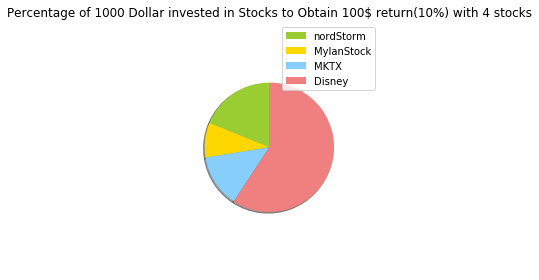

In [9]:
showx = x1.loc[x1['level'] > 0]
labels = showx['i']
sizes = showx['level']
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90)
plt.legend(patches, labels, loc="best")
plt.title('Percentage of 1000 Dollar invested in Stocks to Obtain 100$ return(10%) with 4 stocks')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [10]:
##Predicting the next 30days using Moving Average from for 4 stocks with the objective of 100$

# reading the data
df = pd.read_csv('CLOSEDATA.csv')
index_count = 0
# setting up the dateFrame and data variable
df['Date'] = pd.to_datetime(df.Date,format='%d-%m-%Y')
df.index = df['Date']
data = df.sort_index(ascending=True, axis=0)

#1000$ investment
budget = 1000
movAverageprofit = 0
pd.options.display.max_columns=None


#companies used for analysis
companies = ["nordStorm","ctlStock","MylanStock","MacyStock","Kohls","AMD","MKTX","Netflix","Disney","Eros"]
#closing Price Data at 10-10-2018
ClosingPriceData = []

#calculate the moving average
for company in companies:
    ClosingPriceData.append(data["10/10/2018"][company])
    train = data[:506][company]
    preds = []
    for mm in range(0,30):
        a = train[:len(train)].sum() + sum(preds)
        b = a/len(train)
        preds.append(b)
        
    #preds[29] is the closing price after 30 days
    numShares = budget * x1["level"][index_count] / ClosingPriceData[index_count][0]
    movAverageprofit += (preds[29] -  ClosingPriceData[index_count][0] ) * numShares
    index_count += 1    


print(movAverageprofit)

-10.189685359409056


/opt/miniconda3/envs/JupyterHub/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
##Predicting the next 30days data of each stock using Linear Regression from for 4 stocks with the objective of 100$
FutureClosingPrice = []

count = 0
budget = 1000;
profit = 0
for index in companies:
    
    df = data[:506][index]
    # A variable for predicting 'n' days out into the future
    forecast_out = 30 #'n=30' days
    #Create another column (the target ) shifted 'n' units up
    df['Prediction'] = data[:506][index].shift(-forecast_out)
    ### Create the independent data set (X)  #######
    # Convert the dataframe to a numpy array
    X = np.array(df.drop(['Prediction']))
    #Remove the last '30' rows
    X = X[:-forecast_out]
    ### Create the dependent data set (y)  #####
    # Convert the dataframe to a numpy array 
    y = np.array(df['Prediction'])
    # Get all of the y values except the last '30' rows
    y = y[:-forecast_out]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    #make y_train,x_train,x_test,y_test 2D array; required for formatting
    y_train= y_train.reshape(-1, 1)
    x_train= x_train.reshape(-1, 1)
    x_test = x_test.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    #clear out all the nans, required for formatting
    ind = np.isnan(y_test)
    y_test[ind] = 0;
    ind = np.isnan(y_train)
    y_train[ind] = 0;
    # Create and train the Linear Regression  Model
    lr = LinearRegression()
    # Train the model
    lr.fit(x_train, y_train)
    #clear out all the nans, required for formattin
    ind = np.isnan(y_test)
    y_test[ind] = 0;
    # Testing Model: Score returns the coefficient of determination R^2 of the prediction. 
    # The best possible score is 1.0
    lr_confidence = lr.score(x_test, y_test)
    x_forecast = np.array(X)[-forecast_out:]
    #make x_forecast required for formatting
    x_forecast= x_forecast.reshape(-1, 1)
    lr_prediction = lr.predict(x_forecast)
    FutureClosingPrice.append(lr_prediction[29]) 
    #profit1,numShares1 x= 50, profit2 x = 100
    numShares = budget * x1["level"][count] / ClosingPriceData[count][0]
    profit += (lr_prediction[29] -  ClosingPriceData[count][0] ) * numShares
    count += 1

print(profit)

/opt/miniconda3/envs/JupyterHub/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/miniconda3/envs/JupyterHub/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/miniconda3/envs/JupyterHub/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

[-25.32088255]


/opt/miniconda3/envs/JupyterHub/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/miniconda3/envs/JupyterHub/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/miniconda3/envs/JupyterHub/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

>Both moving average and linear regression showed us that with a budget of 1000 dollars; you will end up loosing money instead of gaining if you aim to get 100 dollar return.

In [12]:
#from linear regression
print(profit[0], "from linear Regression for 4 stocks objective of 100")
#from moving average
print(movAverageprofit, "from Moving Average for 4 stocks objective of 100")

-25.32088254599661 from linear Regression for 4 stocks objective of 100
-10.189685359409056 from Moving Average for 4 stocks objective of 100


# How About With 3 Stocks to return the objective of 100?

In [13]:
%%gams
positive variable threestock100Dollar(i);
model type2portfolio "return of 100 with 3 stocks" / totstock1,expreturn1,riskfactor1,eq1,stocks_chosen3/;  
option optCr = 1e-6;
threestock100Dollar.l(i) = x1.l(i);
solve type2portfolio  using miqcp minimizing risk1;
display x1.l;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Integer (8),20.3836,14,21,MIQCP,SBB,0.193


In [14]:
%gams_pull -d x1
soln=x1.loc[x1['level'] > 0]
soln.set_index('i',inplace=True)
soln.sort_values(by='level')

,level,marginal,lower,upper,scale
i,,,,,
MKTX,0.121494,4.940656e-324,0.0,inf,1.0
nordStorm,0.276317,0.000000e+00,0.0,inf,1.0
Disney,0.602189,0.000000e+00,0.0,inf,1.0


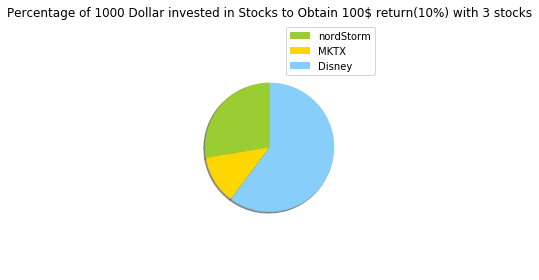

In [15]:
showx = x1.loc[x1['level'] > 0]
labels = showx['i']
sizes = showx['level']
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90)
plt.legend(patches, labels, loc="best")
plt.title('Percentage of 1000 Dollar invested in Stocks to Obtain 100$ return(10%) with 3 stocks')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [16]:
##Predicting the next 30days using Moving Average from for 3 stocks with the objective of 100$

# reading the data
df = pd.read_csv('CLOSEDATA.csv')
index_count = 0
# setting up the dateFrame and data variable
df['Date'] = pd.to_datetime(df.Date,format='%d-%m-%Y')
df.index = df['Date']
data = df.sort_index(ascending=True, axis=0)

#1000$ investment
budget = 1000
movAverageprofit = 0
pd.options.display.max_columns=None


#companies used for analysis
companies = ["nordStorm","ctlStock","MylanStock","MacyStock","Kohls","AMD","MKTX","Netflix","Disney","Eros"]
#closing Price Data at 10-10-2018
ClosingPriceData = []

#calculate the moving average
for company in companies:
    ClosingPriceData.append(data["10/10/2018"][company])
    train = data[:506][company]
    preds = []
    for mm in range(0,30):
        a = train[:len(train)].sum() + sum(preds)
        b = a/len(train)
        preds.append(b)
        
    #preds[29] is the closing price after 30 days
    numShares = budget * x1["level"][index_count] / ClosingPriceData[index_count][0]
    movAverageprofit += (preds[29] -  ClosingPriceData[index_count][0] ) * numShares
    index_count += 1    


print(movAverageprofit)

-39.431819887828006


/opt/miniconda3/envs/JupyterHub/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
##Predicting the next 30days data of each stock using Linear Regression for 3 stocks with the objective of 100$
FutureClosingPrice = []

count = 0
budget = 1000;
profit = 0
for index in companies:
    
    df = data[:506][index]
    # A variable for predicting 'n' days out into the future
    forecast_out = 30 #'n=30' days
    #Create another column (the target ) shifted 'n' units up
    df['Prediction'] = data[:506][index].shift(-forecast_out)
    ### Create the independent data set (X)  #######
    # Convert the dataframe to a numpy array
    X = np.array(df.drop(['Prediction']))
    #Remove the last '30' rows
    X = X[:-forecast_out]
    ### Create the dependent data set (y)  #####
    # Convert the dataframe to a numpy array 
    y = np.array(df['Prediction'])
    # Get all of the y values except the last '30' rows
    y = y[:-forecast_out]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    #make y_train,x_train,x_test,y_test 2D array; required for formatting
    y_train= y_train.reshape(-1, 1)
    x_train= x_train.reshape(-1, 1)
    x_test = x_test.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    #clear out all the nans, required for formatting
    ind = np.isnan(y_test)
    y_test[ind] = 0;
    ind = np.isnan(y_train)
    y_train[ind] = 0;
    # Create and train the Linear Regression  Model
    lr = LinearRegression()
    # Train the model
    lr.fit(x_train, y_train)
    #clear out all the nans, required for formattin
    ind = np.isnan(y_test)
    y_test[ind] = 0;
    # Testing Model: Score returns the coefficient of determination R^2 of the prediction. 
    # The best possible score is 1.0
    lr_confidence = lr.score(x_test, y_test)
    x_forecast = np.array(X)[-forecast_out:]
    #make x_forecast required for formatting
    x_forecast= x_forecast.reshape(-1, 1)
    lr_prediction = lr.predict(x_forecast)
    FutureClosingPrice.append(lr_prediction[29]) 
    #profit1,numShares1 x= 50, profit2 x = 100
    numShares = budget * x1["level"][count] / ClosingPriceData[count][0]
    profit += (lr_prediction[29] -  ClosingPriceData[count][0] ) * numShares
    count += 1

print(profit)

/opt/miniconda3/envs/JupyterHub/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/miniconda3/envs/JupyterHub/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/miniconda3/envs/JupyterHub/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

[-46.49118333]


/opt/miniconda3/envs/JupyterHub/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/miniconda3/envs/JupyterHub/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/miniconda3/envs/JupyterHub/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

> Both linear Regression and Moving Average showed that we end up loosing money if we aim to make 100 dollar return with 3 stocks as well.

In [18]:
#from linear regression
print(profit[0], "from linear Regression 3 stocks objective of 100")
#from moving average
print(movAverageprofit, "from Moving Average with 3 stocks objective of 100")

-46.49118332978793 from linear Regression 3 stocks objective of 100
-39.431819887828006 from Moving Average with 3 stocks objective of 100


> Although we still make loss, investing in 4 stocks seems like a less loss option compared to investing in 3 stocks to get 100 Dollar Return.

## How about investing in 4 stocks to get 50 Dollar Return?

In [19]:
%%gams
model type3portfolio  "return of 50 with 4 stocks" / totstock2,expreturn2,riskfactor2,eq2,stocks_chosen2/;  
option optCr = 1e-6;
solve type3portfolio   using miqcp minimizing risk2;
display x.l;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Integer (8),3.8405,14,21,MIQCP,SBB,0.297


In [20]:
%gams_pull -d x
soln=x.loc[x['level'] > 0]
soln.set_index('i',inplace=True)
soln.sort_values(by='level')

,level,marginal,lower,upper,scale
i,,,,,
MKTX,0.046929,0.000000e+00,0.0,inf,1.0
MylanStock,0.201969,0.000000e+00,0.0,inf,1.0
Disney,0.259630,4.940656e-324,0.0,inf,1.0
Eros,0.491472,4.940656e-324,0.0,inf,1.0


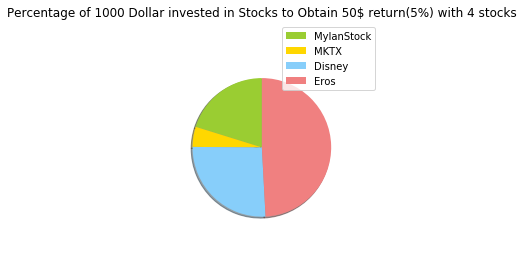

In [21]:
showx = x.loc[x['level'] > 0]
labels = showx['i']
sizes = showx['level']
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90)
plt.legend(patches, labels, loc="best")
plt.title('Percentage of 1000 Dollar invested in Stocks to Obtain 50$ return(5%) with 4 stocks')
plt.axis('equal')
plt.tight_layout()
plt.show()



In [22]:
##Predicting the next 30days using Moving Average for 4 stocks with the objective of 50$

# reading the data
df = pd.read_csv('CLOSEDATA.csv')
index_count = 0
# setting up the dateFrame and data variable
df['Date'] = pd.to_datetime(df.Date,format='%d-%m-%Y')
df.index = df['Date']
data = df.sort_index(ascending=True, axis=0)

#1000$ investment
budget = 1000
movAverageprofit = 0
pd.options.display.max_columns=None


#companies used for analysis
companies = ["nordStorm","ctlStock","MylanStock","MacyStock","Kohls","AMD","MKTX","Netflix","Disney","Eros"]
#closing Price Data at 10-10-2018
ClosingPriceData = []

#calculate the moving average
for company in companies:
    ClosingPriceData.append(data["10/10/2018"][company])
    train = data[:506][company]
    preds = []
    for mm in range(0,30):
        a = train[:len(train)].sum() + sum(preds)
        b = a/len(train)
        preds.append(b)
        
    #preds[29] is the closing price after 30 days
    numShares = budget * x["level"][index_count] / ClosingPriceData[index_count][0]
    movAverageprofit += (preds[29] -  ClosingPriceData[index_count][0] ) * numShares
    index_count += 1    


print(movAverageprofit)

100.3502885940081


/opt/miniconda3/envs/JupyterHub/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
##Predicting the next 30days data of each stock using Linear Regression for 4 stocks with the objective of 50$
FutureClosingPrice = []

count = 0
budget = 1000;
profit = 0
for index in companies:
    
    df = data[:506][index]
    # A variable for predicting 'n' days out into the future
    forecast_out = 30 #'n=30' days
    #Create another column (the target ) shifted 'n' units up
    df['Prediction'] = data[:506][index].shift(-forecast_out)
    ### Create the independent data set (X)  #######
    # Convert the dataframe to a numpy array
    X = np.array(df.drop(['Prediction']))
    #Remove the last '30' rows
    X = X[:-forecast_out]
    ### Create the dependent data set (y)  #####
    # Convert the dataframe to a numpy array 
    y = np.array(df['Prediction'])
    # Get all of the y values except the last '30' rows
    y = y[:-forecast_out]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    #make y_train,x_train,x_test,y_test 2D array; required for formatting
    y_train= y_train.reshape(-1, 1)
    x_train= x_train.reshape(-1, 1)
    x_test = x_test.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    #clear out all the nans, required for formatting
    ind = np.isnan(y_test)
    y_test[ind] = 0;
    ind = np.isnan(y_train)
    y_train[ind] = 0;
    # Create and train the Linear Regression  Model
    lr = LinearRegression()
    # Train the model
    lr.fit(x_train, y_train)
    #clear out all the nans, required for formattin
    ind = np.isnan(y_test)
    y_test[ind] = 0;
    # Testing Model: Score returns the coefficient of determination R^2 of the prediction. 
    # The best possible score is 1.0
    lr_confidence = lr.score(x_test, y_test)
    x_forecast = np.array(X)[-forecast_out:]
    #make x_forecast required for formatting
    x_forecast= x_forecast.reshape(-1, 1)
    lr_prediction = lr.predict(x_forecast)
    FutureClosingPrice.append(lr_prediction[29]) 
    #profit1,numShares1 x= 50, profit2 x = 100
    numShares = budget * x["level"][count] / ClosingPriceData[count][0]
    profit += (lr_prediction[29] -  ClosingPriceData[count][0] ) * numShares
    count += 1

print(profit)


/opt/miniconda3/envs/JupyterHub/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/miniconda3/envs/JupyterHub/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/miniconda3/envs/JupyterHub/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

[37.48015507]


/opt/miniconda3/envs/JupyterHub/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/miniconda3/envs/JupyterHub/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/miniconda3/envs/JupyterHub/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

>Both linear Regression and Moving Average showed that we end up gaining money if we aim to make 50 dollar return with 4 stocks as well. 

In [24]:
#from linear regression
print(profit[0], "from linear Regression 4 stocks objective of 50")
#from moving average
print(movAverageprofit, "from Moving Average with 4 stocks objective of 50")

37.480155068326276 from linear Regression 4 stocks objective of 50
100.3502885940081 from Moving Average with 4 stocks objective of 50


> While Moving Average exceeds our target by far, linear regression falls short to obtain 50 Dollar Return, although they both make profit. 

## How about investing in 3 stocks to get 50 Dollar Return?

In [25]:
%%gams
model type4portfolio  "return of 50 with 3 stocks" / totstock2,expreturn2,riskfactor2,eq2,stocks_chosen4/;  
option optCr = 1e-6;
solve type4portfolio using miqcp minimizing risk2;
display x.l;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Integer (8),4.304,14,21,MIQCP,SBB,0.305


In [26]:
%gams_pull -d x
soln=x.loc[x['level'] > 0]
soln.set_index('i',inplace=True)
soln.sort_values(by='level')

,level,marginal,lower,upper,scale
i,,,,,
MKTX,0.055955,4.940656e-324,0.0,inf,1.0
Disney,0.299341,0.000000e+00,0.0,inf,1.0
Eros,0.644705,0.000000e+00,0.0,inf,1.0


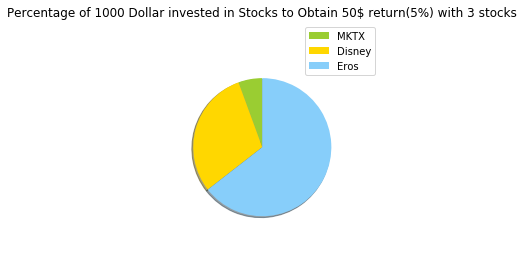

In [27]:
showx = x.loc[x['level'] > 0]
labels = showx['i']
sizes = showx['level']
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90)
plt.legend(patches, labels, loc="best")
plt.title('Percentage of 1000 Dollar invested in Stocks to Obtain 50$ return(5%) with 3 stocks')
plt.axis('equal')
plt.tight_layout()
plt.show()



In [28]:
##Predicting the next 30days using Moving Average from for 3 stocks with the objective of 50$

# reading the data
df = pd.read_csv('CLOSEDATA.csv')
index_count = 0
# setting up the dateFrame and data variable
df['Date'] = pd.to_datetime(df.Date,format='%d-%m-%Y')
df.index = df['Date']
data = df.sort_index(ascending=True, axis=0)

#1000$ investment
budget = 1000
movAverageprofit = 0
pd.options.display.max_columns=None


#companies used for analysis
companies = ["nordStorm","ctlStock","MylanStock","MacyStock","Kohls","AMD","MKTX","Netflix","Disney","Eros"]
#closing Price Data at 10-10-2018
ClosingPriceData = []

#calculate the moving average
for company in companies:
    ClosingPriceData.append(data["10/10/2018"][company])
    train = data[:506][company]
    preds = []
    for mm in range(0,30):
        a = train[:len(train)].sum() + sum(preds)
        b = a/len(train)
        preds.append(b)
        
    #preds[29] is the closing price after 30 days
    numShares = budget * x["level"][index_count] / ClosingPriceData[index_count][0]
    movAverageprofit += (preds[29] -  ClosingPriceData[index_count][0] ) * numShares
    index_count += 1    


print(movAverageprofit)
#50$ target is better supposedly give us 100$ return
#but if you aim for 100$ you will end up with a loss of 10$

85.88115820848608


/opt/miniconda3/envs/JupyterHub/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
##Predicting the next 30days data of each stock using Linear Regression for 3 stocks with the objective of 50$
FutureClosingPrice = []

count = 0
budget = 1000;
profit = 0
for index in companies:
    
    df = data[:506][index]
    # A variable for predicting 'n' days out into the future
    forecast_out = 30 #'n=30' days
    #Create another column (the target ) shifted 'n' units up
    df['Prediction'] = data[:506][index].shift(-forecast_out)
    ### Create the independent data set (X)  #######
    # Convert the dataframe to a numpy array
    X = np.array(df.drop(['Prediction']))
    #Remove the last '30' rows
    X = X[:-forecast_out]
    ### Create the dependent data set (y)  #####
    # Convert the dataframe to a numpy array 
    y = np.array(df['Prediction'])
    # Get all of the y values except the last '30' rows
    y = y[:-forecast_out]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    #make y_train,x_train,x_test,y_test 2D array; required for formatting
    y_train= y_train.reshape(-1, 1)
    x_train= x_train.reshape(-1, 1)
    x_test = x_test.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    #clear out all the nans, required for formatting
    ind = np.isnan(y_test)
    y_test[ind] = 0;
    ind = np.isnan(y_train)
    y_train[ind] = 0;
    # Create and train the Linear Regression  Model
    lr = LinearRegression()
    # Train the model
    lr.fit(x_train, y_train)
    #clear out all the nans, required for formattin
    ind = np.isnan(y_test)
    y_test[ind] = 0;
    # Testing Model: Score returns the coefficient of determination R^2 of the prediction. 
    # The best possible score is 1.0
    lr_confidence = lr.score(x_test, y_test)
    x_forecast = np.array(X)[-forecast_out:]
    #make x_forecast required for formatting
    x_forecast= x_forecast.reshape(-1, 1)
    lr_prediction = lr.predict(x_forecast)
    FutureClosingPrice.append(lr_prediction[29]) 
    #profit1,numShares1 x= 50, profit2 x = 100
    numShares = budget * x["level"][count] / ClosingPriceData[count][0]
    profit += (lr_prediction[29] -  ClosingPriceData[count][0] ) * numShares
    count += 1

print(profit)

/opt/miniconda3/envs/JupyterHub/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/miniconda3/envs/JupyterHub/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/miniconda3/envs/JupyterHub/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

[19.9438853]


/opt/miniconda3/envs/JupyterHub/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/miniconda3/envs/JupyterHub/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/miniconda3/envs/JupyterHub/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

In [30]:
#from linear regression
print(profit[0], "from linear Regression 3 stocks objective of 50")
#from moving average
print(movAverageprofit, "from Moving Average with 3 stocks objective of 50")

19.943885298025926 from linear Regression 3 stocks objective of 50
85.88115820848608 from Moving Average with 3 stocks objective of 50


> Both linear Regression and Moving Average showed that we end up gaining money if we aim to make 50 dollar return with 3 stocks as well.However, investing in 4 stocks would be more profitable.

## Assumptions


>1.The  assumptions are based on the Markowitz model [1],
          
          •Risk of a portfolio is based on the variability of returns from the said portfolio.
          •An investor is risk averse.
          •Analysis is based on single period model of investment.
          •An investor either maximizes his portfolio return for a given level of risk or maximizes his return for 
            the minimum risk.
          •An investor is rational in nature.
         
> 2. We don’t allow the investor to short sell.

> 3.There will be no transaction costs when stocks are purchased.

> 4. There are only ten stocks to invest in – 
nordStorm,ctlStock,MylanStock,MacyStock,Kohls,AMD,MKTX,Netflix,Disney,Eros. 
The closing prices for these stocks are taken from " https://www.tiingo.com/ "and tabulated in excel sheet attached in the.zip 
folder.The mean and covariance is calculated using Excel.

> 5. We assumed different scenarios to compare and analysis the better portfolio amongst them such as,
   > (i) Having a return of 100 dollars or 50 dollars.
   >(ii) Choosing over 4 or 3 stocks to invest in.
   
> 6. We use two different methods to predict the future prices over the 30 days (2018-10-10 to 2018-11-09):
    >(i) Using linear regression
    >(ii) Using Moving Average

# Conclusion:

From the portfolio model, we can arrive at the following conclusions:



>       1. Investing in 4 stocks gives a better return than investing in 3 stocks as indicated by both the linear regression and moving average models. It also reduces the loss in case, a loss occurs. As seen from the model, investing in 4 stocks for a return of 100 dollars results in lesser loss than investing in 3 stocks.
    
>       2. Setting a target of 100 dollars return for a budget of 1000 dollars is a bad choice.It results in investment in stocks with  higher fluctuations (more variance) but ends up with a loss at the end of one month as indicated by both  the moving average and linear regression methods as seen above. This is in accordance with the Markowitz Model, "Risk of a portfolio is based on the variability of returns from the said portfolio.[1]".  Setting a target of 50 dollars return for a budget of 1000 dollars is a better choice. It results in investment in stocks with lesser fluctuations (less variance) and gives a profitable return at the end of one month as indicated by both the models. It nearly achieves the set target or maybe more.

 >      3. Nearly 50% or more of the total budget is invested in the entertainment sector in all the scenarios. This indicates that more diversification does not necessarily yield more return or is based on lesser risk.

 >      4. The linear regression model fits the real world expectation of stock prices better than the moving average model.  The fluctuations in price are accounted in the linear regression model while in the moving average, the prediction is a linear increase over the entire time period taken. Thus, the results from the linear regression model could be considered more reliable.

 > In conclusion, we found that investing in 4 stocks for a return of 50 dollars is the best performing portfolio for a budget of 1000 dollars and a time period of 30 days.(10th of October 2018 to 9th of November 2018).

## References:

> [1] https://en.wikipedia.org/wiki/Markowitz_model

> [2] https://www2.isye.gatech.edu/~sahmed/isye6669/notes/portfolio